In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data loading and modification

In [2]:
df = pd.read_excel('titanic.xls', dtype={'pclass': 'category'})

df['floor'] = df.cabin.apply(lambda s: ord('A') - ord(s[0]) if isinstance(s, str) else s)
df.floor[df.floor == -19] = np.nan

df.boat = df.boat.notna()

df['surname'] = df['name'].apply(lambda s: s.split(',')[0])

bins = pd.interval_range(0, df.age.max(), freq=10)
df['age_group'] = pd.cut(df.age, bins)

df['relatives'] = df['sibsp'] + df['parch']
df['has_relatives'] = df['relatives'] > 0

# dropping these as they are mostly nans or meaningless
df = df.drop(columns=['home.dest', 'body', 'cabin', 'ticket', 'parch', 'sibsp', 'embarked'])
df.head()

C:\Users\hadar\AppData\Local\Temp/ipykernel_33944/3088127036.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.floor[df.floor == -19] = np.nan


,pclass,survived,name,sex,age,fare,boat,floor,surname,age_group,relatives,has_relatives
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,211.3375,True,-1.0,Allen,"(20.0, 30.0]",0,False
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,151.5500,True,-2.0,Allison,"(0.0, 10.0]",3,True
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,151.5500,False,-2.0,Allison,"(0.0, 10.0]",3,True
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,151.5500,False,-2.0,Allison,"(20.0, 30.0]",3,True
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,151.5500,False,-2.0,Allison,"(20.0, 30.0]",3,True


## How is age distributed in every pclass and in every age?


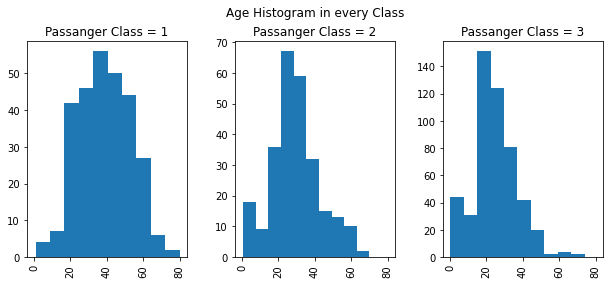

In [3]:
axes = df.hist('age', by='pclass', sharex=True, layout=(1, 3), figsize=(10, 4))
for i, ax in enumerate(axes):
    ax.set_title('Passanger Class = {}'.format(i + 1))
plt.suptitle('Age Histogram in every Class', y=1.02)
plt.show()

## Which family had lost the most members?

In [4]:
family_total = df.groupby('surname').size()
family_survived = df.groupby('surname')['survived'].sum()
family_died = family_total - family_survived
lost_most = family_died.idxmax()
print('The family which had lost the most members is {}, losing {} members'.format(lost_most, family_died[lost_most]))

The family which had lost the most members is Sage, losing 11 members


## Is there a connection between the age of a passenger and it's chance of survival? What about his pclass? 

In [5]:
def plot_survival_chance_by_variable(df, var, figsize=(10, 4)):
    survival_stats = df.groupby(var).mean()['survived']
    survival_stats.plot(y='mean', legend=False, figsize=figsize, marker='.',
                        title='Passengar Chance of survival by {}'.format(var.title()))

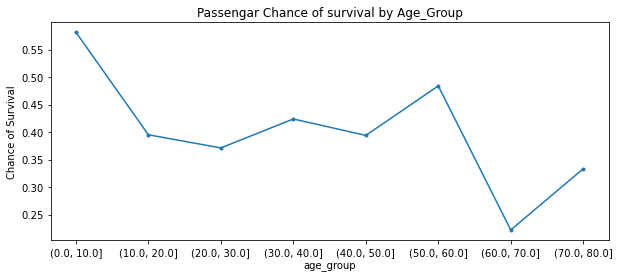

In [6]:
plot_survival_chance_by_variable(df, 'age_group')
plt.ylabel('Chance of Survival')
plt.show()

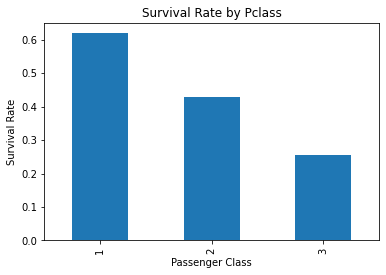

In [7]:
def survival_rate_bar(df, var):
    total = df.groupby(var).size()
    survival_rate = df.groupby(var)['survived'].mean().plot.bar(
        ylabel='Survival Rate', title='Survival Rate by {}'.format(var.title()))

survival_rate_bar(df, 'pclass')
plt.xlabel('Passenger Class')
plt.show()

## What is the relation between survivors to deceased in every pclass?


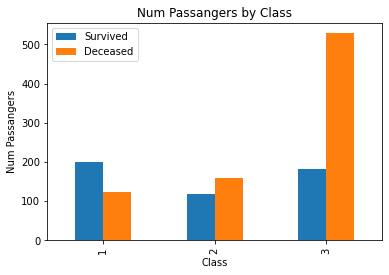

In [8]:
total = df.groupby('pclass').size()
survived = df.groupby('pclass')['survived'].sum()
deceased = total - survived
pd.DataFrame({'Survived': survived, 'Deceased': deceased}).plot.bar(
    xlabel='Class', ylabel='Num Passangers', title='Num Passangers by Class')
plt.show()

# Freestyle

It seems like far more people died in class 3 than any other class, both absolutely and relative to the number of passengers in that class.

This may be due to many factors, age, number of family members. We'll check which other variables are also correlated with the chances of survival.

We'll start by looking at a key differences inherent in the difference classes.

## Inherent Class Features

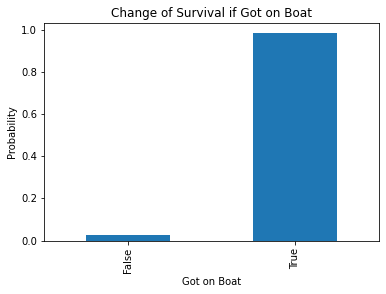

In [9]:
df.groupby('boat').survived.mean().plot.bar(xlabel='Got on Boat', ylabel='Probability', 
                                            title='Change of Survival if Got on Boat')
plt.show()

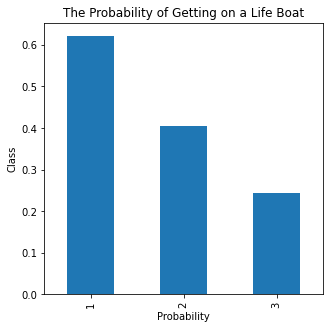

In [10]:
df.groupby('pclass').boat.mean().plot.bar(figsize=(5, 5), title='The Probability of Getting on a Life Boat',
                                         xlabel='Probability', ylabel='Class')
plt.show()

Getting on a life boat is crucial for survival and class 3 passengers have a much lower chance to get on one, why is that?

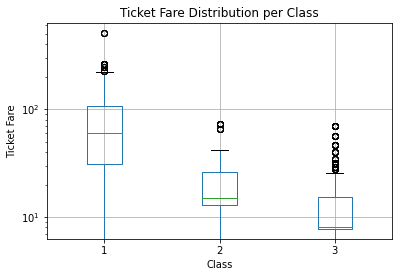

In [12]:
df.boxplot('fare', by='pclass')
plt.title('Ticket Fare Distribution per Class')
plt.suptitle('')
plt.yscale('log')
plt.ylabel('Ticket Fare')
plt.xlabel('Class')
plt.show()

Class 3 passengers pay the least money, why does that affect their chance of getting on a life boat?

### Boat Floor?

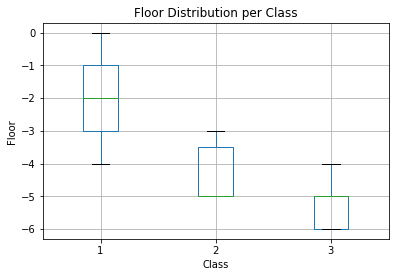

In [29]:
df.boxplot('floor', by='pclass')
plt.title('Floor Distribution per Class')
plt.ylabel('Floor')
plt.xlabel('Class')
plt.suptitle('')
plt.show()

# Violinplot?

Class 3 passengers get the lowest floors, is that the reason they have the lowest chance to get on a lifeboat?

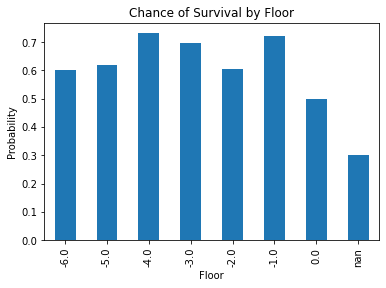

In [14]:
df.groupby('floor', dropna=False).survived.mean().plot.bar(
    xlabel='Floor', ylabel='Probability', title='Chance of Survival by Floor')
plt.show()

In [15]:
print('{:.2%}'.format(df.floor.isna().mean()))

77.54%


It doesn't seem like floor is correlated with chance of survival, but over 77% of passengers don't have a floor value, so its tough to tell if it holds any data.

### Num Passangers

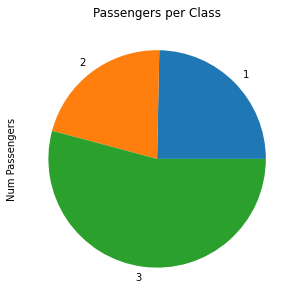

In [16]:
df.groupby('pclass').size().plot.pie(figsize=(5, 5), ylabel='Num Passengers', title='Passengers per Class')
plt.show()

Class 3 has the most passengers, this probably makes it harder for them to make it to the ship's deck from their room.

## Passenger Statistics in Different Classes

We'll continue to look into other variables that may correlate with low survival rate.

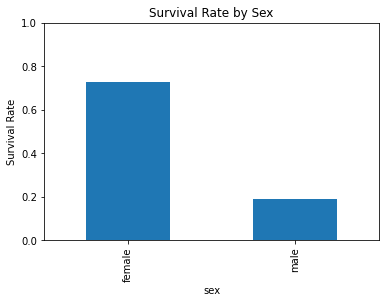

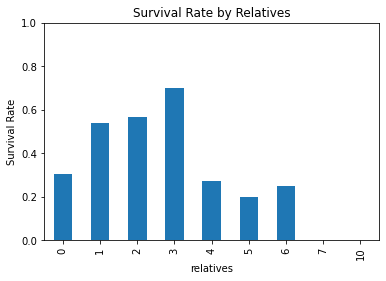

In [17]:
for column in ['sex', 'relatives']:
    survival_rate_bar(df, column)
    plt.ylim(top=1)
    plt.show()

The following observations rise from the above figures:

* Women have a much higher survival rate.

* People with few relatives (1 to 3) have a much higher chance of survival.

### Age

Is the survival rate difference between men and women consistent between different age groups

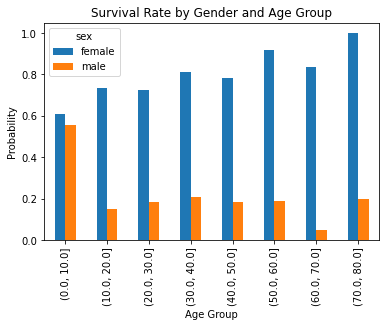

In [20]:
df.groupby(['age_group', 'sex'])['survived'].mean().unstack(level=1).plot.bar(
    title='Survival Rate by Gender and Age Group', xlabel='Age Group', ylabel='Probability')
plt.show()

It is not! The survival rate of boys and girls is the same but at all other ages, men have a much lower survival rate.

It could be that classes 1 and 2 have more families and therefore more children, whereas class 3 has more single men, thereby increasing bringing class 3's survival rate down.

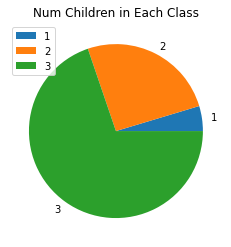

In [21]:
df[df.age <= 10].groupby('pclass').size().plot.pie(ylabel='', title='Num Children in Each Class')
plt.legend()
plt.show()

In [22]:
print('{:.2%} of the passengers in class 3 are children'.format(
    (df[df.pclass == 3].age <= 10).sum() / (df.pclass == 3).sum()))

8.46% of the passengers in class 3 are children


Contrary to our earlier hypothesis, class 3 has the most children by far! This goes against class 3 having the lowest survival rate and the most men, as boys and girls have the same mortality rate, unlike men and women which have vastly different survival rates. This is explained by having so few children in class 3.

### Relatives and Sex

What about people with many relatives? They have the lowest chance of survival.

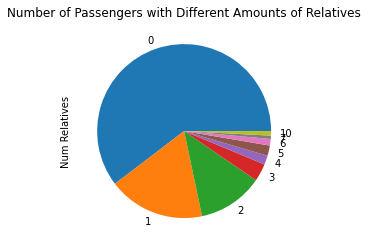

In [23]:
df.groupby('relatives').size().plot.pie(
    ylabel='Num Relatives', title='Number of Passengers with Different Amounts of Relatives')
plt.show()

There are very few people with more than 3 relatives, it is fair to ignore them, and focus mainly on the difference between having no relatives and having relatives.

We will now check if class 3 has higher relative amount of men and people without relatives.

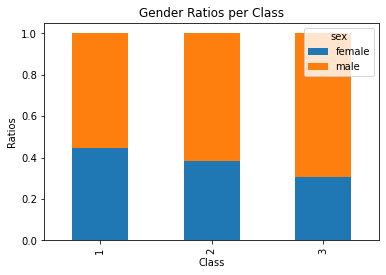

In [24]:
def normalize_rows(df):
    return df.divide(df.sum(axis=1), axis=0)

normalize_rows(df.groupby(['pclass', 'sex']).size().unstack()).plot.bar(
    stacked=True, title='Gender Ratios per Class', xlabel='Class', ylabel='Ratios')
plt.show()

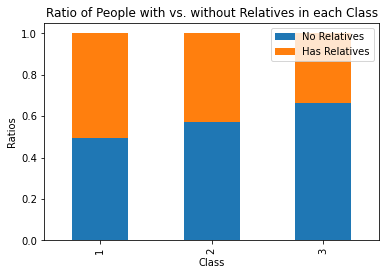

In [25]:
normalize_rows(df.groupby(['pclass', 'has_relatives']).size().unstack()).plot.bar(
    stacked=True, title='Ratio of People with vs. without Relatives in each Class', xlabel='Class', ylabel='Ratios')
plt.legend(['No Relatives', 'Has Relatives'])
plt.show()

Class 3 has the highest relative amounts of both men and people without relatives, which are two populations with lower survival rate.

We got that men die more and people without relatives die more. Having relatives may be the dominant factor in survival, lets see if the difference in survival rate between people of different sex still exists when separating to single people and people with relatives. 

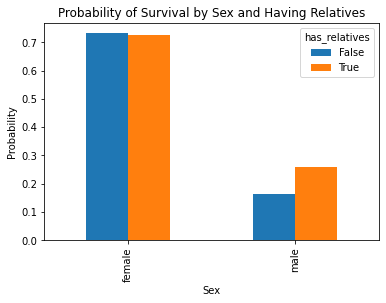

In [26]:
df.groupby(['has_relatives', 'sex'])['survived'].mean().unstack(0).plot.bar(
    xlabel='Sex', ylabel='Probability', title='Probability of Survival by Sex and Having Relatives')
plt.show()

It does! Women have a much higher survival rate then men and have almost the same survival rate regardless of whether they have relatives on the ship, on the other hand, men have a lower survival rate if they have no relatives.

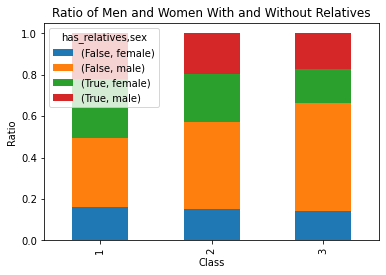

In [44]:
normalize_rows(df.groupby(['pclass', 'sex', 'has_relatives']).size().unstack().unstack()).plot.bar(
    stacked=True, xlabel='Class', ylabel='Ratio', title='Ratio of Men and Women With and Without Relatives')
plt.show()

Indeed class 3 has the highest ratio of men with no relatives.

Let's compare the survival ratio of men, women, and children.

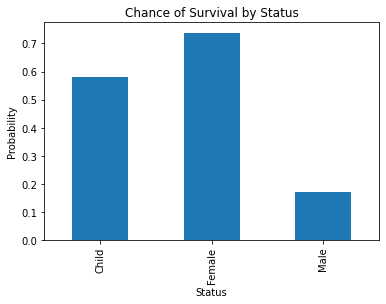

In [54]:
def get_status(row):
    if row.age <= 10:
        return 'Child'
    return row.sex.title()

df['status'] = df.apply(get_status, axis=1)
df.groupby(['status']).survived.mean().plot.bar(
    ylabel='Probability', xlabel='Status', title='Chance of Survival by Status')
plt.show()

[Women and children first](https://en.wikipedia.org/wiki/Women_and_children_first)